# Metadata

```yaml
Course:   DS 5001 
Module:   06 Homework
Topic:    Similarity and Distance Measures
Author:   R.C. Alvarado
Date:     19 February 2023 (revised)
```

# Instructions

In this week’s code exercise, you will compute and explore vector space distances between documents for a corpus of Jane Austen’s novels.

* Use the notebook from class as your guide, as well as any relevant previous notebooks.
* For source data, use the `LIB` and `CORPUS` tables you used last week for the Austem and Melville set. These are in the `/output` directory of 
the course repo. 
* Note that you can use the functions you created last week to compute `TFIDF`; if you had problems with these, you may use functions in the homework key.
* Also, you will need to generate the `VOCAB` table from the Austen corpus; you can import your work from your last homework if you'd like. 

To prepare to answer the questions below, complete the following tasks:

* Add a feature to the `LIB` table for the publication year of the book, using the data provided below. 
  * Create a label for each book using a combination of the year and the book title. 
  * _Scholarly side note_: This is the *publication* year in most cases. For works published posthumously, the year refers to when scholars think the work was actually completed. Note also, there is often a lag between date of completion and data of publication. We will not concern ourselves with these nuances here, but it is always helpful to understand how your data are actually produced.
* Bring into your notebook the functions you created previously to generate a `BOW` table and compute `TFIDF` values. 
Extend the `TFIDF` function so that it also returns the `DFIDF` value for each term in the `VOCAB`.
* Apply these functions to the corpus of Austen's works only, and using *chapters* as bags and `max` as the `TF` count method. 
* Reduce the number of features in the returned `TFIDF` matrix to the **1000 most significant terms**, using `DFIDF` as your significance measure and only using terms whose maximum part-of-speech belongs to this set: `NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS`. Note, these are all **open** categories, excluding proper nounns.
* "Collapse" `TFIDF` matrix that it contains mean `TFIDF` of each term by book. This will result in a matrix with book IDs as rows, and significant terms as columns.
* Use the reduced and collapsed `TFIDF` matrix to compute distance missures between all pairs of books, as we computed in Lab (using `pdist()`). See the table below for the measures to take.
  * As in the template, use the appropriate normed vector space for each metric.
  * You will need to create a table of book pairs (e.g. `PAIRS`).
  * You do *not* need to compute k-means clusters. 
* Create hierarchical agglomerative cluster diagrams for the distance measures, using the appropriate linkage type for each distance measure. Again, see the table below for the appropriate linkage type.
  * Use the labels you created in the `LIB` in your dendograms to help interpret your results.
  
Once you have completed these tasks, answer the questions below.

**Distance Measure and Linkage Method Combos**
```
| Distance Measure | Norming | Linkage  |
|------------------|---------|----------|  
| cityblock        | None    | weighted |
| cosine           | None    | ward     |
| euclidean        | L2      | ward     |  
| jaccard          | L0      | weighted | 
| jensenshannon    | L1      | weighted |
```

**Dates of Austen's Works**
```
| book_id | year | title                                     |
|---------|------|-------------------------------------------|
| 158     | 1815 | Emma                                      |
| 946     | 1794 | Lady Susan                                |
| 1212    | 1790 | Love And Freindship And Other Early Works |
| 141     | 1814 | Mansfield Park                            |
| 121     | 1803 | Northanger Abbey                          |
| 105     | 1818 | Persuasion                                |
| 1342    | 1813 | Pride and Prejudice                       |
| 161     | 1811 | Sense and Sensibility                     |
```

## Q1 

What are the top 10 nouns by `DFIDF`, sorted in descending order? Include plural nouns, but don't include proper nouns. 

Don't worry if your list does not include some terms that have the same 
weights as words in the list. Just take what Pandas gives you with `.head(10)` after sorting with ascending set to `False`.

**Answer**:

```
respect     174 NN	177.266344	0.008183
fortune     222 NN	177.261968	0.010642
marriage    246 NN	177.261968	0.013575
question    171 NN	177.258990	0.006774
ladies      240 NNS	177.258990	0.011303
behaviour   200 NN	177.240001	0.010849
farther     181 NN	177.240001	0.006979
advantage   166 NN	177.217644	0.007974
girl        254 NN	177.209470	0.012677
voice       228 NN	177.209470	0.009163
```


## Q2 

Grouping your `TFIDF` results by book, and taking the mean `TFIDF` of all terms per book, what is Austen's most "significant" book? 

This value is computed from the `TFIDF` matrix your function returned.

**Answer**: Northanger Abbey or Emma, depending on whether or not they used the reduced vocabulary for the TFIDF matrix feature space. The question is ambiguous.

## Q3 

Using the dendograms you generated, which distance measure most clearly distinguishes Austen's two youthful works from her later works?

That is, which measure show the greatest separation between the first two work and the rest?

Note that the two youthful works were published before 1800.

**Answer**: **Jaccard weighted** shows the most distance between the early and the later works.

## Q4

Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years?  

**Answer**: **No**.

## Q5

Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her Juvenilia, i.e. her two works written as a young adult. Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works?

**Answer**: The all show that the _Northanger Abbey_ is closer to her juvenalia than her other adult works.

# Code

## Set Up

In [1]:
data_home = '../../repo/lessons/data'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [3]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform

## Prepare the Data

Get `LIB`, `CORPUS`, and `VOCAB` for Jane Austen's works.

### Import data from previous work

In [4]:
LIB_raw = pd.read_csv(f'{data_home}/output/{data_prefix}-LIB.csv').set_index('book_id')
CORPUS_raw = pd.read_csv(f'{data_home}/output/{data_prefix}-CORPUS.csv').set_index(OHCO)

### Select Austen's works from `LIB`

In [5]:
LIB = LIB_raw[LIB_raw.author.str.contains("AUS")].copy().sort_index()

In [6]:
LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps
book_id,,,,,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61


### Add publication dates to `LIB`

In [7]:
YYYY = """
book_id year    title
158     1815    Emma
946     1794    Lady Susan
1212    1790    Love And Freindship And Other Early Works
141     1814    Mansfield Park
121     1803    Northanger Abbey
105     1818    Persuasion
1342    1813    Pride and Prejudice
161     1811    Sense and Sensibility
""".split('\n')[1:-1]

In [8]:
YEARS = pd.DataFrame([line.split()[:2] for line in YYYY][1:], columns=['book_id', 'year'])
YEARS.book_id = YEARS.book_id.astype('int')
YEARS = YEARS.set_index('book_id')

In [9]:
LIB['year'] = YEARS

In [10]:
LIB['label'] = LIB.apply(lambda x: f"{x.year}: {x.title}", 1)

In [11]:
LIB['label']

book_id
105                  1818: PERSUASION
121            1803: NORTHANGER ABBEY
141              1814: MANSFIELD PARK
158                        1815: EMMA
161       1811: SENSE AND SENSIBILITY
946                  1794: LADY SUSAN
1212    1790: LOVE AND FREINDSHIP SIC
1342        1813: PRIDE AND PREJUDICE
Name: label, dtype: object

### Select Austen's works from `CORPUS`

In [12]:
CORPUS = CORPUS_raw.loc[LIB.index.values.tolist(), ['pos', 'token_str', 'term_str']].copy()

In [13]:
CORPUS

pos   token_str   term_str
book_id chap_id para_num sent_num token_num                            
105     1       1        0        0          NNP         Sir        sir
                                  1          NNP      Walter     walter
                                  2          NNP     Elliot,     elliot
                                  3           IN          of         of
                                  4          NNP    Kellynch   kellynch
...                                          ...         ...        ...
1342    61      18       0        8           CC         and        and
                                  9          NNP  Prejudice,  prejudice
                                  10          IN          by         by
                                  11         NNP        Jane       jane
                                  12         NNP      Austen     austen

[780873 rows x 3 columns]

### Generate Austen's `VOCAB`

In [14]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['max_pos'] = CORPUS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [66]:
CORPUS.value_counts(['term_str','pos']).unstack(fill_value=0)

pos,DT,TO,CC,IN,PRP,VBD,PRP$,RB,VB,VBZ,...,RBS,RP,NNS,JJS,WP$,FW,UH,NNPS,POS,LS
term_str,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10th,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zealous,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zealously,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
zephyr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
VOCAB

,n,max_pos
term_str,,
the,28274,DT
to,26029,TO
and,24060,CC
of,22927,IN
a,14301,DT
...,...,...
contagion,1,NN
purposed,1,VBN
stanwix,1,NNP


## Vectorize the Data

Generate a `BOW` and computer `TFIDF` and derived quantities.

In [16]:
tf_method = 'max'
bag = CHAP
vocab_filter = 'dfidf'
n_terms = 1000
# pos_list = "CC CD DT EX FW IN MD PDT POS PRP PRP$ RP SYM TO UH WDT WP WP$ WRB LS".split() # Closed categories
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # Open categories with no proper nouns

### Define functions

Use the function you created previously.

In [17]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [18]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

### Get `BOW` by chapter with `max`

In [19]:
bag

['book_id', 'chap_id']

In [20]:
BOW = create_bow(CORPUS, bag)

In [58]:
BOW

n
book_id chap_id term_str   
105     1       1         2
                15        1
                16        1
                1760      1
                1784      1
...                      ..
1342    61      you       7
                young     1
                younger   1
                yours     1
                youth     1

[233724 rows x 1 columns]

In [21]:
tf_method

'max'

In [22]:
TFIDF, DFIDF = get_tfidf(BOW, tf_method)

In [59]:
TFIDF

term_str           0         1   10  10000  10th  11th   12  12th  1399  13th  \
book_id chap_id                                                                 
105     1        0.0  0.119092  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        2        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        3        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        4        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        5        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
...              ...       ...  ...    ...   ...   ...  ...   ...   ...   ...   
1342    57       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        58       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        59       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        60       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        61       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   

term_str         ...  youthful  youths  yrs         z      zeal   zealous  \
book_id chap_id  ...                                                        
105     1        ...  0.043417     0.0  0.0  0.067611  0.000000  0.000000   
        2        ...  0.000000     0.0  0.0  0.000000  0.000000  0.061689   
        3        ...  0.000000     0.0  0.0  0.000000  0.036998  0.000000   
        4        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        5        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
...              ...       ...     ...  ...       ...       ...       ...   
1342    57       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        58       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        59       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        60       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        61       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   

term_str         zealously  zephyr  zigzags  ł20000  
book_id chap_id                                      
105     1              0.0     0.0      0.0     0.0  
        2              0.0     0.0      0.0     0.0  
        3              0.0     0.0      0.0     0.0  
        4              0.0     0.0      0.0     0.0  
        5              0.0     0.0      0.0     0.0  
...                    ...     ...      ...     ...  
1342    57             0.0     0.0      0.0     0.0  
        58             0.0     0.0      0.0     0.0  
        59             0.0     0.0      0.0     0.0  
        60             0.0     0.0      0.0     0.0  
        61             0.0     0.0      0.0     0.0  

[334 rows x 14745 columns]

In [23]:
TFIDF[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

,term_str,sister,little,only,enough,same,are,something,elizabeth,it,who
book_id,chap_id,,,,,,,,,,
946,23,0.000000,0.000000,0.007807,0.000000,0.015653,0.010224,0.014950,0.000000,0.005440,0.000000
1342,22,0.000000,0.010021,0.004392,0.007263,0.008805,0.002875,0.000000,0.316586,0.008500,0.005598
141,33,0.006478,0.006823,0.011960,0.009890,0.017985,0.011747,0.011451,0.000000,0.008102,0.022868
161,3,0.042731,0.003751,0.004931,0.024465,0.019773,0.003229,0.009442,0.000000,0.009544,0.028284
141,29,0.000000,0.010180,0.008030,0.000000,0.005367,0.019280,0.046133,0.000000,0.009740,0.010236
161,26,0.051823,0.011371,0.005980,0.000000,0.029975,0.003916,0.011451,0.000000,0.006250,0.005717
158,32,0.009821,0.018964,0.006800,0.003749,0.031812,0.022262,0.013021,0.000000,0.009301,0.018780
161,8,0.000000,0.000000,0.010606,0.035082,0.000000,0.006945,0.010155,0.000000,0.009033,0.006760
1342,39,0.008699,0.012216,0.006023,0.000000,0.008050,0.015774,0.007689,0.260505,0.006839,0.010236


### Reduce `VOCAB` to `n` most significant terms

In [24]:
# DFIDF.sort_values(ascending=False)

In [25]:
VOCAB['dfidf'] = DFIDF

In [69]:
VOCAB.dfidf.sort_values(ascending=False).head(10)

term_str
forward     177.266344
thinking    177.266344
greatest    177.266344
stay        177.266344
among       177.266344
respect     177.266344
four        177.261968
assure      177.261968
fortune     177.261968
marriage    177.261968
Name: dfidf, dtype: float64

In [26]:
VOCAB['mean_tfidf'] = TFIDF.mean()

In [27]:
n_terms

1000

In [28]:
vocab_filter

'dfidf'

In [29]:
VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values(vocab_filter, ascending=False)\
    .head(n_terms).index

### Reduce `TFIDF` feature space

###  Collapse `TFIDF` by mean bag

In [30]:
M = TFIDF[VIDX].fillna(0).groupby('book_id').mean() # MUST FILLNA

In [31]:
M

term_str,greatest,stay,respect,thinking,forward,fortune,assure,marriage,believed,new,...,laugh,force,couple,increasing,niece,intercourse,habits,guess,scene,till
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.003233,0.010584,0.006140,0.011340,0.009262,0.013589,0.010205,0.011468,0.008962,0.010591,...,0.000873,0.000543,0.003639,0.001605,0.000000,0.009714,0.006116,0.004542,0.004032,0.007750
121,0.007326,0.008810,0.004111,0.008241,0.006748,0.010054,0.008954,0.005660,0.009190,0.016896,...,0.007287,0.004548,0.002833,0.005080,0.000000,0.003060,0.002851,0.010006,0.003930,0.010037
141,0.010356,0.009412,0.009049,0.010821,0.009500,0.006946,0.004308,0.007412,0.008376,0.009582,...,0.004720,0.003853,0.005363,0.005369,0.018120,0.004981,0.009751,0.003738,0.013626,0.009845
158,0.007157,0.011392,0.011402,0.014596,0.008882,0.010334,0.014604,0.009475,0.011059,0.009415,...,0.008453,0.003532,0.009435,0.005039,0.009043,0.007385,0.006200,0.011692,0.002252,0.009874
161,0.009488,0.008128,0.006497,0.005347,0.006474,0.012934,0.009847,0.013288,0.008158,0.010615,...,0.009584,0.006641,0.006831,0.004190,0.002029,0.000584,0.001201,0.006222,0.002234,0.010393
946,0.015570,0.005638,0.010156,0.001255,0.010188,0.005375,0.005513,0.021950,0.009788,0.000000,...,0.001439,0.002964,0.000000,0.007314,0.010203,0.007928,0.000000,0.006438,0.000000,0.009533
1212,0.010051,0.000884,0.003126,0.003517,0.001501,0.011411,0.011138,0.016403,0.000000,0.005096,...,0.000000,0.003442,0.007730,0.000000,0.000000,0.003257,0.000000,0.000000,0.007929,0.007163
1342,0.005553,0.012313,0.009518,0.007312,0.006757,0.014328,0.013715,0.020465,0.010656,0.007232,...,0.013745,0.004699,0.004362,0.005092,0.010457,0.003360,0.001980,0.003690,0.009177,0.011637


In [32]:
# M2 = TFIDF.fillna(0).groupby('book_id').mean()[VIDX] # MUST FILLNA

In [33]:
# M2

### Normalize `TFIDF` for distance measuring

In [34]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

### Generate doc pairs

In [35]:
PAIRS = M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [36]:
general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (M,  'cosine', 'cosine', euclidean_method),
    (M,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

In [37]:
for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)

In [38]:
PAIRS.style.background_gradient('GnBu', high=.5)

In [39]:
PAIRS.corr().style.background_gradient(cmap='GnBu', high=.5)

,correl,euclidean,cosine,cityblock,jaccard,js
correl,1.000000,0.093538,0.100085,0.105621,0.147002,0.126429
euclidean,0.093538,1.000000,0.998540,0.985599,0.962054,0.996756
cosine,0.100085,0.998540,1.000000,0.980221,0.963509,0.996019
cityblock,0.105621,0.985599,0.980221,1.000000,0.943970,0.985831
jaccard,0.147002,0.962054,0.963509,0.943970,1.000000,0.973634
js,0.126429,0.996756,0.996019,0.985831,0.973634,1.000000


## Visualize

### Define function

In [40]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [41]:
def draw_hca(sims, linkage_method='complete', figsize=(7.5, 5)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.label.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{label}–{linkage_method}", fontsize=20)
    
#     return fig

### Generate for each combo

<Figure size 640x480 with 0 Axes>

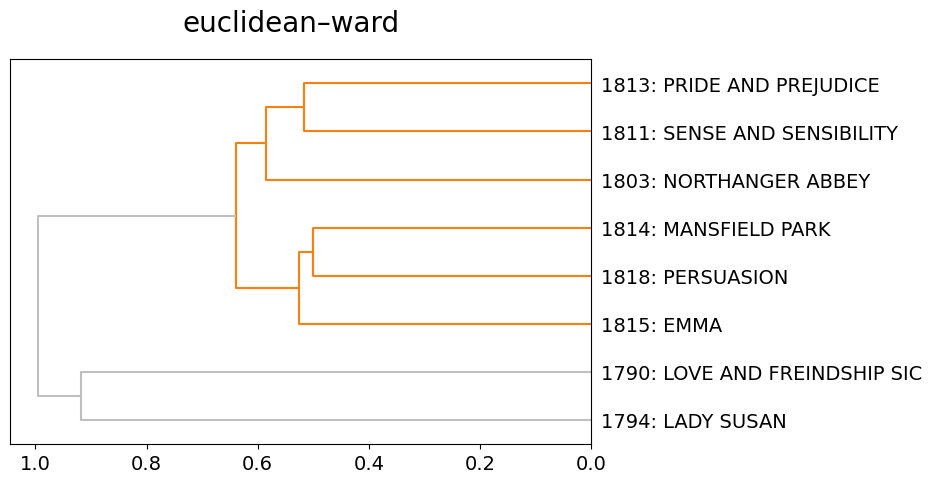

<Figure size 640x480 with 0 Axes>

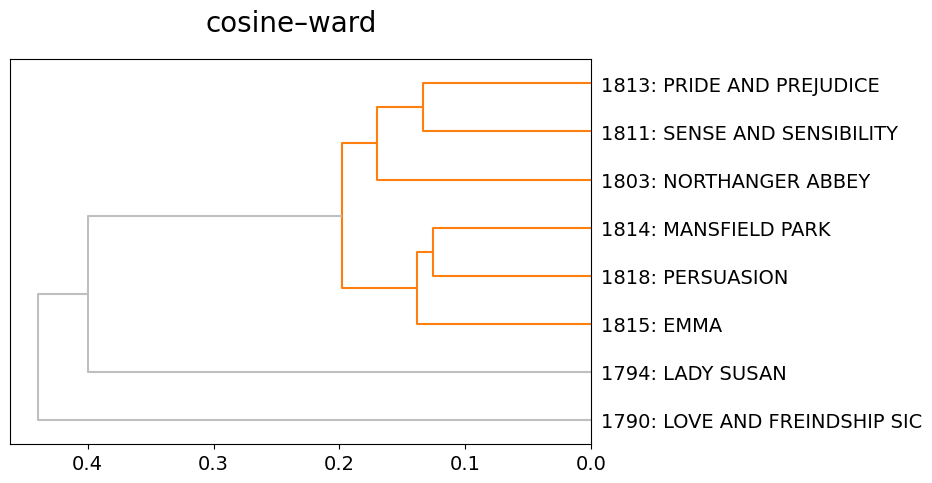

<Figure size 640x480 with 0 Axes>

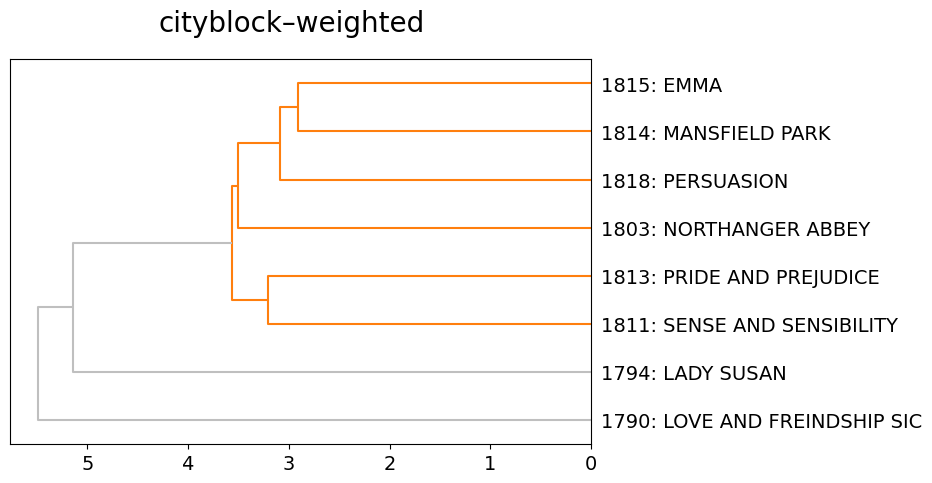

<Figure size 640x480 with 0 Axes>

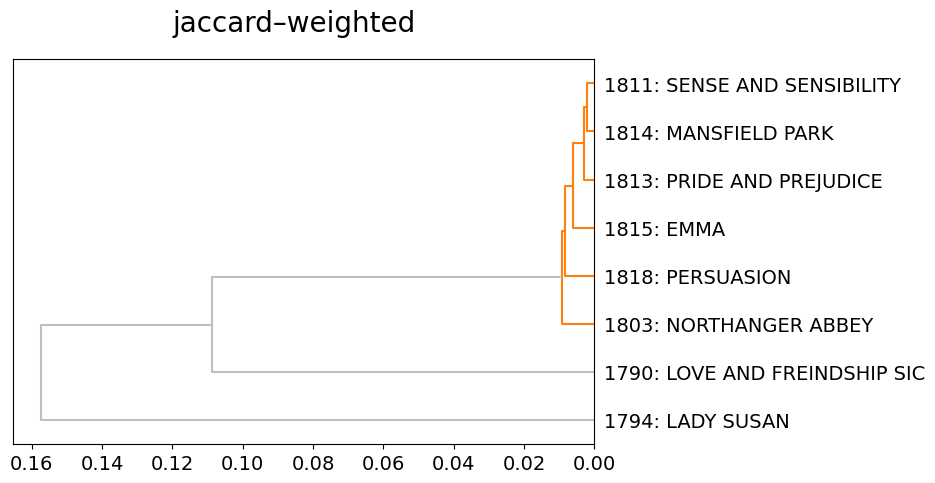

<Figure size 640x480 with 0 Axes>

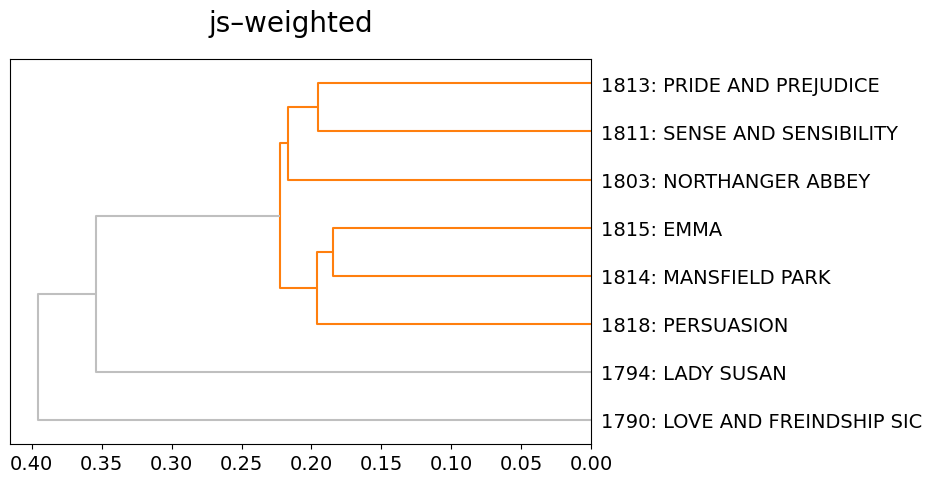

In [42]:
for X, metric, label, linkage in combos:
    draw_hca(PAIRS[label], linkage_method=linkage)

## Save

In [43]:
BOW_REDUCED = M.stack().to_frame('tfidf_mean')
BOW_REDUCED['binary']   = L0.stack()
BOW_REDUCED['tfidf_l1'] = L1.stack()
BOW_REDUCED['tfidf_l2'] = L2.stack()
BOW_REDUCED = BOW_REDUCED.sort_index()

In [44]:
BOW_REDUCED

tfidf_mean  binary  tfidf_l1  tfidf_l2
book_id term_str                                          
105     able          0.007063       1  0.000977  0.027764
        absence       0.004201       1  0.000581  0.016514
        absolutely    0.003214       1  0.000445  0.012635
        accept        0.004572       1  0.000633  0.017974
        accepted      0.002638       1  0.000365  0.010370
...                        ...     ...       ...       ...
1342    yes           0.013016       1  0.001619  0.046311
        yesterday     0.005150       1  0.000641  0.018323
        younger       0.017307       1  0.002153  0.061578
        yours         0.009408       1  0.001170  0.033472
        youth         0.004538       1  0.000564  0.016144

[8000 rows x 4 columns]

# Answers

## Q1

Top 10 Nouns using DFIDF?

In [45]:
VOCAB['dfidf'] = DFIDF

In [46]:
VOCAB.sort_values('dfidf', ascending=False).query('max_pos == "NN" or max_pos == "NNS"').head(10)

,n,max_pos,dfidf,mean_tfidf
term_str,,,,
respect,174,NN,177.266344,0.008183
fortune,222,NN,177.261968,0.010642
marriage,246,NN,177.261968,0.013575
question,171,NN,177.258990,0.006774
ladies,240,NNS,177.258990,0.011303
behaviour,200,NN,177.240001,0.010849
farther,181,NN,177.240001,0.006979
advantage,166,NN,177.217644,0.007974
girl,254,NN,177.209470,0.012677


## Q2 

Most significant book?

**NOTE:** There is an ambiguity regarding the TFIDF table from which to compute significance. We will accept both answers.

Collapse TFIDF by book and get mean tfidf.

In [90]:
LIB.loc[TFIDF.stack().groupby('book_id').mean().idxmax()].title

'NORTHANGER ABBEY'

In [89]:
LIB.loc[TFIDF[VIDX].stack().groupby('book_id').mean().idxmax()].title

'EMMA'